In [1]:
import numpy as np
import scipy.sparse as sc
import matplotlib.pyplot as plt

In [2]:
def MyDissection(A, nx_grid, ny_grid, level):
    A0 = A
    N_grid = nx_grid * ny_grid # grid size

    if [nx_grid, ny_grid][level % 2] < 3:
        L = np.linalg.cholesky(A)
        U = L.T
        P = np.eye(N_grid)
        return P, L, U, A

    if level % 2 == 0: # vertical split
        nx_Omega1 = nx_grid // 2 # the number of columns in Omega1
        N_Omega1 = nx_Omega1 * ny_grid # size of Omega1
        ind_Omega3 = np.arange(N_Omega1, N_Omega1 + ny_grid, dtype=np.int32) # indices of Omega3
        N_Omega3 = np.size(ind_Omega3) # size of Omega3
        ind_Omega1 = np.arange(N_Omega1, dtype=np.int32) # indices of Omega1
        ind_Omega2 = np.arange(N_Omega1 + N_Omega3, N_grid, dtype=np.int32) # indices of Omega2
        N_Omega2 = np.size(ind_Omega2) # size of Omega2
        ny_Omega1 = ny_grid
        nx_Omega2 = nx_grid - nx_Omega1 - 1
        ny_Omega2 = ny_grid
    else: # horizontal split
        ny_Omega1 = ny_grid // 2 # the number of rows in Omega1
        N_Omega1 = ny_Omega1 * nx_grid # size of Omega1
        ind_Omega3 = np.arange(ny_Omega1, N_grid, ny_grid, dtype=np.int32) # indices of Omega3
        ny_Omega2 = ny_grid - ny_Omega1 - 1
        ind_Omega1 = np.zeros(ny_Omega1 * nx_grid, dtype=np.int32)
        ind_Omega2 = np.zeros(ny_Omega2 * nx_grid, dtype=np.int32)
        if nx_grid > 1:
            for k in range(nx_grid):
                ind1_start = k * ny_grid
                ind2_start = k * ny_grid + ny_Omega1 + 1
                j1_start = k * ny_Omega1
                j2_start = k * ny_Omega2
                ind_Omega1[j1_start : j1_start + ny_Omega1] = np.arange(ind1_start, ind1_start + ny_Omega1, dtype=np.int32)
                ind_Omega2[j2_start : j2_start + ny_Omega2] = np.arange(ind2_start, ind2_start + ny_Omega2, dtype=np.int32)
        else: # case nx_grid == 1
            ind_Omega1 = np.arange(ny_Omega1, dtype=np.int32)
            ind_Omega2 = np.arange(ny_Omega1 + 1, ny_Omega1 + 1 + ny_Omega2, dtype=np.int32)
        N_Omega2 = np.size(ind_Omega2) # size of Omega2
        N_Omega3 = np.size(ind_Omega3) # size of Omega3
        nx_Omega1 = nx_grid
        nx_Omega2 = nx_grid

    I11 = np.ix_(ind_Omega1, ind_Omega1)
    I22 = np.ix_(ind_Omega2, ind_Omega2)
    A11 = A[I11]
    A22 = A[I22]

    # recurse to process the subdomains Omega1 and Omega2
    P11, L11, U11, A11 = MyDissection(A11, nx_Omega1, ny_Omega1, level + 1)
    P22, L22, U22, A22 = MyDissection(A22, nx_Omega2, ny_Omega2, level + 1)

    # compute the permutation matrix; the matrix P1 places P11 and P22 to places corresponding to their indices in the indexing system
    P1 = np.eye(N_grid)
    P1[np.ix_(ind_Omega1, ind_Omega1)] = P11
    P1[np.ix_(ind_Omega2, ind_Omega2)] = P22
    # the matrix P permutes the blocks P11, P22, P33 for the new indexing system
    P = sc.coo_array((np.ones(N_grid), (np.arange(N_grid), np.concatenate((ind_Omega1, ind_Omega2, ind_Omega3)))), shape=(N_grid, N_grid)).toarray()
    P = P @ P1
    A = P @ A0 @ np.transpose(P)

    # extract nonzero blocks of A
    new_ind_Omega1 = np.arange(N_Omega1, dtype=np.int32)
    new_ind_Omega2 = np.arange(N_Omega1, N_Omega1 + N_Omega2, dtype=np.int32)
    new_ind_Omega3 = np.arange(N_Omega1 + N_Omega2, N_grid, dtype=np.int32)
    # I11 = np.ix_(new_ind_Omega1, new_ind_Omega1)
    # I22 = np.ix_(new_ind_Omega2, new_ind_Omega2)
    I33 = np.ix_(new_ind_Omega3, new_ind_Omega3)
    I13 = np.ix_(new_ind_Omega1, new_ind_Omega3)
    I23 = np.ix_(new_ind_Omega2, new_ind_Omega3)
    I31 = np.ix_(new_ind_Omega3, new_ind_Omega1)
    I32 = np.ix_(new_ind_Omega3, new_ind_Omega2)

    # Compute Schur complement
    # S33 = A33 - A31*(U11\(L11\A13)) - A32*(U22\(L22\A23))
    aux1 = sc.linalg.spsolve_triangular(L11, A[I13], lower=True)
    aux1 = sc.linalg.spsolve_triangular(U11, aux1, lower=False)
    aux1 = A[I31] @ aux1
    aux2 = sc.linalg.spsolve_triangular(L22, A[I23], lower=True)
    aux2 = sc.linalg.spsolve_triangular(U22, aux2, lower=False)
    aux2 = A[I32] @ aux2
    S33 = A[I33] - aux1 - aux2

    # find the LU of the Schur complement
    L33 = np.linalg.cholesky(S33)
    U33 = L33.T

    # form LU decomposition of A
    L = sc.block_diag((L11, L22, L33)).toarray()
    L[I31] = np.transpose(sc.linalg.spsolve_triangular(np.transpose(U11), np.transpose(A[I31]), lower=True))
    L[I32] = np.transpose(sc.linalg.spsolve_triangular(np.transpose(U22), np.transpose(A[I32]), lower=True))
    U = sc.block_diag((U11, U22, U33)).toarray()
    U[I13] = sc.linalg.spsolve_triangular(L11, A[I13], lower=True)
    U[I23] = sc.linalg.spsolve_triangular(L22, A[I23], lower=True)

    return P, L, U, A

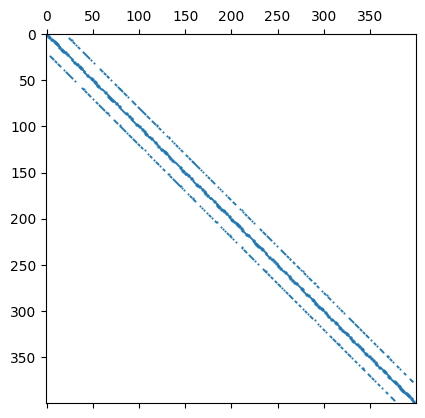

In [3]:
# Problem setup
nx = 20
ny = 20
data = np.load('hw8_data.npz', allow_pickle=True)
L_symm, b_symm, y = data.values()
A = np.pad(-L_symm, 1)
A[0, 0] = 1
A[-1, -1] = 1

b = np.zeros((nx * ny, 1))
b[1:-1] = -b_symm
b[-1] = 1

sol = np.zeros((nx * ny, 1))
sol[1:-1] = np.linalg.solve(-L_symm, -b_symm)
sol[-1] = 1

# Plot sparsity pattern of the original matrix A
plt.spy(A, marker='s', markersize=0.5)
plt.show()

/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/2866989856.py:77: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  aux1 = sc.linalg.spsolve_triangular(L11, A[I13], lower=True)
/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/2866989856.py:78: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  aux1 = sc.linalg.spsolve_triangular(U11, aux1, lower=False)
/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/2866989856.py:80: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  aux2 = sc.linalg.spsolve_triangular(L22, A[I23], lower=True)
/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/2866989856.py:81: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  aux2 = sc.linalg.spsolve_triangular(U22, aux2, lower=False)
/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/2866989856.py:91: SparseE

norm(sol-x) = 3.886786189380998e-12


/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/3040504061.py:18: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  y = sc.linalg.spsolve_triangular(L, Pb, lower=True)
/var/folders/bs/9cpp7hg51177gbwvldbbx3f40000gn/T/ipykernel_48409/3040504061.py:19: SparseEfficiencyWarning: CSR matrix format is required. Converting to CSR matrix.
  x_aux = sc.linalg.spsolve_triangular(U, y, lower=False)


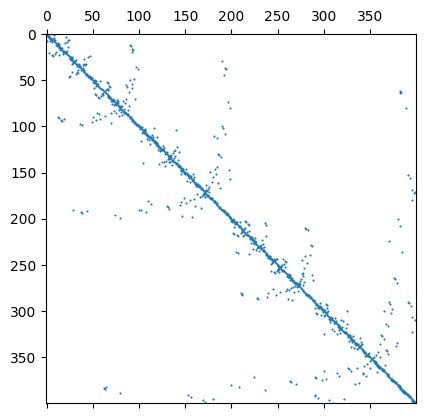

In [4]:
level = 0
# make A a dense matrix
# A = A.toarray()
[P, L, U, A] = MyDissection(A, nx, ny, level)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.spsolve_triangular.html
# Nested Dissection algorithm solves Ax=b
# It rearranges A using a permutation matrix P that it constructs
# Note: P' = P^{-1}
# Hence it solves PAP'Px = Pb
# It decomposes PAP' = LU
# Hence we need to solve LUPx = Pb
# It first solves Ly = Pb by y = L\(Pb)
# Then it solves UPx = y by x = P'(U\y)

# scipy.sparse.linalg.spsolve_triangular(A, b, lower=True, overwrite_A=False,
# overwrite_b=False, unit_diagonal=False)[source]
Pb = P.dot(b)
y = sc.linalg.spsolve_triangular(L, Pb, lower=True)
x_aux = sc.linalg.spsolve_triangular(U, y, lower=False)
x = np.transpose(P).dot(x_aux)

print(f'norm(sol-x) = {np.linalg.norm(sol - x)}')

A = sc.csr_matrix(A)
plt.spy(A, marker='s', markersize=0.5)
plt.show()